In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import torch
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import Dataset, DataLoader  
from skimage import io
from torch import nn

In [3]:
verification_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Soft Computing/Dataset2_softcomputing2/Dataset_2/verification_train.csv', low_memory=False)
verification_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [4]:
verification_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Soft Computing/Dataset2_softcomputing2/Dataset_2/verification_test.csv', low_memory=False)
verification_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,0,0,34,29,7,0,11,24,0,0,3,3,1,0,1,1,0,0,0,0,0,4,0,0,1,0,0,0,0,0,...,242,245,224,245,234,0,3,0,0,0,0,0,0,0,0,0,0,0,0,37,69,94,123,127,138,138,142,145,135,125,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,209,190,181,150,170,193,180,219,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,...,248,238,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,174,233,155,0,65,235,216,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,17,0,0,0,0,0,0,0,0,12,94,68,14,0,0,0,0,0,0,0,0,0,0,0,38,106,94,89,94,68,...,0,0,0,0,0,0,87,12,26,0,0,0,0,0,0,0,46,50,29,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,161,212,138,150,169,164,176,202,255,183,26,0,0,0,0,0,0,0,0,0,0,0,1,0,0,129,221,255,255,215,...,255,255,254,252,255,101,196,254,252,100,0,0,0,0,0,168,232,225,0,41,172,147,148,153,155,146,137,141,143,137,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,204,235,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,69,0,2,0,0,0,0,0,0,0,0,0,0


In [5]:
# Hyperparameters

batch_size = 100
num_iters = 40000
input_dim = 28*28
num_hidden = 200  
output_dim = 10

learning_rate = 0.01  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class Dataset2(Dataset): 
    def __init__(self, data, transform = None):
        self.data_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.data_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [7]:
train_data = Dataset2(verification_train, transform=transforms.Compose([transforms.ToTensor()]))
test_data = Dataset2(verification_test, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_data, batch_size=100)
test_loader = DataLoader(train_data, batch_size=100)

In [8]:
print(len(train_data))
print(len(test_data))

60000
10000


In [9]:
'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [10]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)        
        self.relu_1 = nn.ReLU()
         
        self.linear_2 = nn.Linear(num_hidden, num_hidden)    
        self.relu_2 = nn.ReLU()
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)   
        self.relu_3 = nn.ReLU()
  
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
    
        self.linear_5= nn.Linear(num_hidden, num_hidden) 
        self.relu_5= nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden) 
        self.relu_6 = nn.ReLU()
  
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        # 1st  layer
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 

In [11]:
'''
INSTANTIATE MODEL CLASS
'''
model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

NeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
'''
TRAIN THE MODEL
'''
Loss = []
Iteration = []
Accuracy = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            Loss.append(loss.item())
            Iteration.append(iter)
            Accuracy.append(accuracy)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.47415274381637573. Accuracy: 80.54
Iteration: 1000. Loss: 0.4238940477371216. Accuracy: 84.06
Iteration: 1500. Loss: 0.4044317603111267. Accuracy: 85.87
Iteration: 2000. Loss: 0.5253264307975769. Accuracy: 86.52
Iteration: 2500. Loss: 0.2078189104795456. Accuracy: 87.16
Iteration: 3000. Loss: 0.5035558342933655. Accuracy: 86.24
Iteration: 3500. Loss: 0.31942495703697205. Accuracy: 86.77
Iteration: 4000. Loss: 0.30711829662323. Accuracy: 88.01
Iteration: 4500. Loss: 0.432549387216568. Accuracy: 88.0
Iteration: 5000. Loss: 0.21764057874679565. Accuracy: 88.23
Iteration: 5500. Loss: 0.3293780982494354. Accuracy: 88.38
Iteration: 6000. Loss: 0.20733946561813354. Accuracy: 88.86
Iteration: 6500. Loss: 0.20599421858787537. Accuracy: 89.0
Iteration: 7000. Loss: 0.30106794834136963. Accuracy: 88.64
Iteration: 7500. Loss: 0.30325809121131897. Accuracy: 86.91
Iteration: 8000. Loss: 0.13547398149967194. Accuracy: 89.16
Iteration: 8500. Loss: 0.2806708514690399. Accuracy: 8

In [14]:
print(Iteration)
print(Loss)
print(Accuracy)

[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500]
[0.47415274381637573, 0.4238940477371216, 0.4044317603111267, 0.5253264307975769, 0.2078189104795456, 0.5035558342933655, 0.31942495703697205, 0.30711829662323, 0.432549387216568, 0.21764057874679565, 0.3293780982494354, 0.20733946561813354, 0.20599421858787537, 0.30106794834136963, 0.30325809121131897, 0.13547398149967194, 0.2806708514690399, 0.29833197593688965, 0.20729412138462067, 0.1890648454427719, 0.24351200461387634, 0.2506975829601288, 0.217217147350311

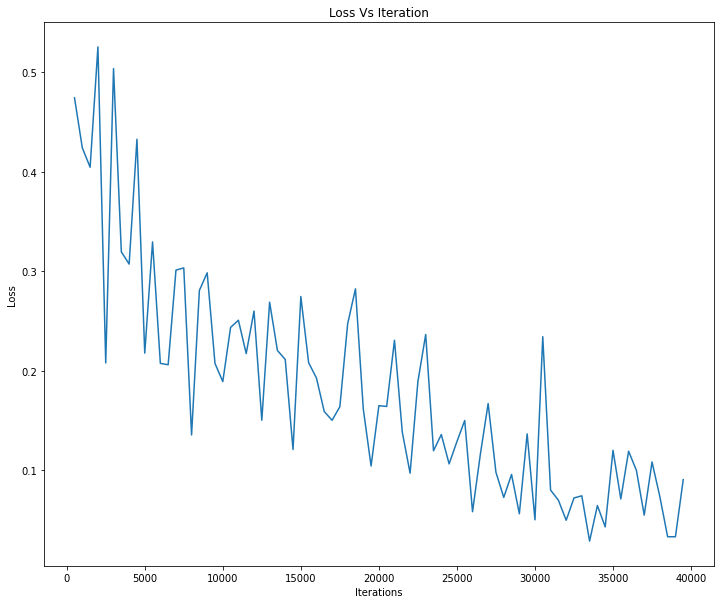

In [15]:
x= np.array(Iteration)
y= np.array(Loss)
plt.figure(figsize=(12,10))
plt.plot(x, y)
plt.title("Loss Vs Iteration")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

In [2]:
Iterat = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500]
Acc = [80.54, 84.06, 85.87, 86.52, 87.16, 86.24, 86.77, 88.01, 88.0, 88.23, 88.38, 88.86, 89.0, 88.64, 86.91, 89.16, 89.08, 88.94, 89.15, 88.96, 89.41, 88.97, 89.36, 89.82, 89.03, 89.31, 88.92, 88.82, 89.9, 89.17, 88.82, 88.67, 89.12, 89.43, 89.03, 88.62, 88.04, 89.44, 89.78, 89.68, 89.65, 88.16, 89.55, 89.25, 90.07, 89.68, 89.97, 89.43, 89.33, 89.93, 89.2, 90.31, 89.55, 89.22, 89.64, 89.95, 89.26, 89.37, 89.77, 89.96, 89.31, 88.57, 89.85, 89.84, 89.06, 89.31, 89.83, 89.63, 89.72, 89.81, 89.54, 89.72, 89.43, 89.56, 88.82, 89.65, 89.75, 89.61, 89.32]

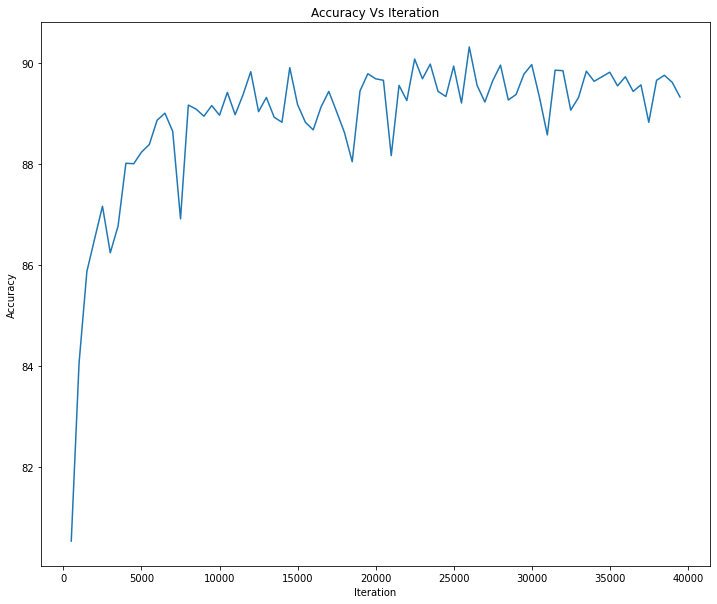

In [6]:
y= np.array(Acc)
x= np.array(Iterat)
plt.figure(figsize=(12,10))
plt.plot(x, y)
plt.title("Accuracy Vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()